In [31]:
using LinearAlgebra
using Plots

In [32]:
fi = ComplexF32(1.0im)

0.0f0 + 1.0f0im

In [33]:
function vec2hermite(v::Vector{Float32})
    N = round(Int, sqrt(length(v)))
    H = zeros(ComplexF32, N, N)
    for i in 1:N
        for j in i:N
            l = N*(i-1) + 2j - i^2
            if(i == j)
                H[i,j] = v[l]
            else
                H[i,j] = v[l-1] + fi*v[l]
            end 
        end
    end
    H = Hermitian(H)
    return H
end

vec2hermite (generic function with 1 method)

In [34]:
function vec2unitary(v::Vector{Float32}, τ::Float32)
    H = vec2hermite(v)
    U = exp(fi*(τ*H))
    return U
end

vec2unitary (generic function with 1 method)

In [35]:
function make_unitary(N::Int, τ::Float32)
    v = rand(Float32, N^2)
    U = vec2unitary(v, τ)
    return U
end

make_unitary (generic function with 1 method)

In [36]:
function norm!(m::Hermitian{ComplexF32, Matrix{ComplexF32}})
    T = real(tr(m))
    m = m/T
end

norm! (generic function with 1 method)

In [37]:
function norm(m::Hermitian{ComplexF32, Matrix{ComplexF32}})
    T = real(tr(m))
    return m/T
end

norm (generic function with 1 method)

In [38]:
function make_rand_dm(dim::Int)
    ρ_vec = rand(Float32, dim^2)
    rt_ρ = vec2hermite(ρ_vec)
    ρ = Hermitian(norm!(Hermitian(rt_ρ*rt_ρ')))
    return ρ
end

make_rand_dm (generic function with 1 method)

In [8]:
test_U = make_unitary(4, 1.0f0)
II = test_U * test_U'
println([real(II[i,i]) for i in 1:4])

Float32[0.99999994, 0.99999994, 0.9999999, 0.99999994]


In [39]:
function ehot(vs::Vector{ComplexF32}, i::Int, e_dim::Int)
    s_dim = length(vs)
    ve = zeros(ComplexF32, e_dim*s_dim)
    ve[(s_dim*(i-1)+1):(s_dim*i)] = vs
    #v2 = vcat(vs, ve)
    return ve
end

ehot (generic function with 1 method)

In [40]:
function make_ev(s_ev::Matrix{ComplexF32}, e_dim::Int)
    #e_vec::Vector{Matrix{Float32}} = []
    s_vec::Vector{Matrix{ComplexF32}} = []
    s_dim = size(s_ev)[1]
    tot_dim = s_dim * e_dim
    println(s_dim)
    for i in 1:s_dim
        sm = zeros(ComplexF32, tot_dim, e_dim)
        for j in 1:e_dim
            sm[:,j] = ehot(s_ev[:,i], j, e_dim)
            #push!(e_vec, twohot(i, j, s_dim))
            #push!(s_vec, ehot(s_ev[:,i], j, e_dim))
        end
        push!(s_vec, sm)
    end
    #=
    for j in 1:e_dim
        em = zeros(Float32, tot_dim, s_dim)
        for i in 1:s_dim
            em[:,i] = twohot(i, j, s_dim, e_dim)
        end
        push!(e_vec, em)
    end=#
    return s_vec
end

make_ev (generic function with 1 method)

In [41]:
function make_Mk(U::Matrix{ComplexF32}, s_vec::Vector{Matrix{ComplexF32}})
    L = size(U)[1]
    e_dim = length(s_vec)
    s_dim = div(L,e_dim)
    Ms::Vector{Matrix{ComplexF32}} = []
    for j in 1:e_dim
        for k in 1:s_dim
            push!(Ms, (s_vec[k]'*U*s_vec[j]))
        end
    end
    return Ms
end

make_Mk (generic function with 1 method)

In [25]:
#=
function make_Mk(U::Matrix{ComplexF32}, s_vec::Vector{Matrix{ComplexF32}}, e_vec::Vector{Matrix{Float32}})
    L = size(U)[1]
    e_dim = length(s_vec)
    s_dim = div(L,e_dim)
    Ms::Vector{Matrix{ComplexF32}} = []
    for j in 1:e_dim
        for k in 1:s_dim
            push!(Ms, (e_vec[k]'*U*s_vec[j]))
        end
    end
    return Ms
end=#

make_Mk (generic function with 1 method)

In [42]:
struct Dime
    s_dim::Int
    e_dim::Int
    tot_dim::Int
    M_size::Int
end

In [86]:
dim = Dime(4, 4, 16, 256)

Dime(4, 4, 16, 256)

In [44]:
function Λρ(ρ::Hermitian{ComplexF32, Matrix{ComplexF32}}, Ms::Vector{Matrix{ComplexF32}}, es::Vector{Float32}, ds::Dime)
    #ρ_vec = zeros(Float32, tot_dim^2)
    Lρ = zeros(ComplexF32, ds.s_dim, ds.s_dim)
    for i in 1:tot_dim
        Lρ += es[div(i-1,ds.e_dim)+1]*Ms[i]'*ρ*Ms[i]
    end
    return Hermitian(Lρ)
end

Λρ (generic function with 2 methods)

In [83]:
testm = make_rand_dm(4)

4×4 Hermitian{ComplexF32, Matrix{ComplexF32}}:
 0.305968+0.0im        0.222911+0.0345511im   …  0.134762+0.22704im
 0.222911-0.0345511im  0.288777+0.0im            0.136423+0.17525im
 0.102993-0.0471291im  0.145913-0.00998307im     0.122371+0.0671969im
 0.134762-0.22704im    0.136423-0.17525im        0.255563+0.0im

In [46]:
function KL_divergence(ρ::Hermitian{ComplexF32, Matrix{ComplexF32}}, σ::Hermitian{ComplexF32, Matrix{ComplexF32}})
    return real(tr(ρ*(log(ρ)-log(σ))))
end

KL_divergence (generic function with 1 method)

In [47]:
struct DMs
    s_dm::Hermitian{ComplexF32, Matrix{ComplexF32}}
    e_dm::Hermitian{ComplexF32, Matrix{ComplexF32}}
    s_evs::Matrix{ComplexF32}
    s_es::Vector{Float32}

    U::Matrix{ComplexF32}
    Ms::Vector{Matrix{ComplexF32}}
end

function init_dms(ds::Dime, τ::Float32)
    s_dm = make_rand_dm(ds.s_dim)
    e_dm = make_rand_dm(ds.e_dim)
    s_es, s_evs = eigen(s_dm)
    U = make_unitary(ds.tot_dim, τ)
    s_evsa = make_ev(s_evs, ds.e_dim)
    Ms = make_Mk(U, s_evsa)
    return DMs(s_dm, e_dm, s_evs, s_es, U, Ms)
end

init_dms (generic function with 1 method)

In [48]:
function Λρ(ρ::Hermitian{ComplexF32, Matrix{ComplexF32}}, dms::DMs, ds::Dime)
    #ρ_vec = zeros(Float32, tot_dim^2)
    Lρ = zeros(ComplexF32, ds.s_dim, ds.s_dim)
    for i in 1:ds.tot_dim
        Lρ += dms.s_es[div(i-1,ds.e_dim)+1]*dms.Ms[i]*ρ*dms.Ms[i]'
    end
    return Hermitian(Lρ)
end

Λρ (generic function with 2 methods)

In [49]:
function Λρd(ρ::Hermitian{ComplexF32, Matrix{ComplexF32}}, dms::DMs, ds::Dime)
    #ρ_vec = zeros(Float32, tot_dim^2)
    Lρ = zeros(ComplexF32, ds.s_dim, ds.s_dim)
    for i in 1:ds.tot_dim
        Lρ += dms.s_es[div(i-1,ds.e_dim)+1]*dms.Ms[i]'*ρ*dms.Ms[i]
    end
    return Hermitian(Lρ)
end

Λρd (generic function with 1 method)

In [64]:
function Λρ2(ρ::Hermitian{ComplexF32, Matrix{ComplexF32}}, dms::DMs, ds::Dime)
    #ρ_vec = zeros(Float32, tot_dim^2)
    Lρ = zeros(ComplexF32, ds.s_dim, ds.s_dim)
    for i in 1:tot_dim
        Lρ += dms.s_es[((i-1)%ds.s_dim)+1]*dms.Ms[i]*ρ*dms.Ms[i]'
    end
    return Hermitian(Lρ)
end

Λρ2 (generic function with 1 method)

In [87]:
test_dms = init_dms(dim, 1.0f0)

4


DMs(ComplexF32[0.27735466f0 + 0.0f0im 0.14923662f0 + 0.004779997f0im 0.077183455f0 + 0.15170638f0im 0.0031349387f0 + 0.15098336f0im; 0.14923662f0 - 0.004779997f0im 0.34990498f0 + 0.0f0im 0.16710548f0 + 0.1318603f0im 0.11406498f0 + 0.08757121f0im; 0.077183455f0 - 0.15170638f0im 0.16710548f0 - 0.1318603f0im 0.18863982f0 + 0.0f0im 0.16203815f0 + 0.024234895f0im; 0.0031349387f0 - 0.15098336f0im 0.11406498f0 - 0.08757121f0im 0.16203815f0 - 0.024234895f0im 0.18410054f0 + 0.0f0im], ComplexF32[0.27870548f0 + 0.0f0im 0.11463947f0 + 0.06979321f0im 0.0029037362f0 + 0.09255348f0im -0.06320894f0 + 0.1388006f0im; 0.11463947f0 - 0.06979321f0im 0.30462077f0 + 0.0f0im 0.14717518f0 + 0.052544672f0im 0.06685462f0 + 0.0004686937f0im; 0.0029037362f0 - 0.09255348f0im 0.14717518f0 - 0.052544672f0im 0.16928783f0 + 0.0f0im 0.13520396f0 - 0.002234432f0im; -0.06320894f0 - 0.1388006f0im 0.06685462f0 - 0.0004686937f0im 0.13520396f0 + 0.002234432f0im 0.2473859f0 + 0.0f0im], ComplexF32[0.09185962f0 + 0.14914782f0im 

In [51]:
kl = KL_divergence(test_dms.s_dm, testm)

0.8201263f0

In [52]:
@show lp = Λρ(test_dms.s_dm, test_dms, dim)
@show tr(lp)

lp = Λρ(test_dms.s_dm, test_dms, dim) = ComplexF32[0.31655082f0 + 0.0f0im 0.17976387f0 + 0.052875564f0im 0.15102462f0 + 0.1352647f0im; 0.17976387f0 - 0.052875564f0im 0.24311842f0 + 0.0f0im 0.21019651f0 + 0.04844262f0im; 0.15102462f0 - 0.1352647f0im 0.21019651f0 - 0.04844262f0im 0.44033048f0 + 0.0f0im]
tr(lp) = 0.99999976f0


0.99999976f0

In [53]:
@show lpd = Λρd(test_dms.s_dm, test_dms, dim)
@show tr(lpd)

lpd = Λρd(test_dms.s_dm, test_dms, dim) = ComplexF32[0.3888164f0 + 0.0f0im 0.21166462f0 + 0.044986635f0im 0.19683951f0 + 0.14142354f0im; 0.21166462f0 - 0.044986635f0im 0.382468f0 + 0.0f0im 0.11418142f0 + 0.02941678f0im; 0.19683951f0 - 0.14142354f0im 0.11418142f0 - 0.02941678f0im 0.2849698f0 + 0.0f0im]
tr(lpd) = 1.0562541f0


1.0562541f0

In [54]:
function nroot_m(ρ::Hermitian{ComplexF32, Matrix{ComplexF32}}, n::Int)
    #ρ_vec = zeros(Float32, tot_dim^2)
    e, v = eigen(ρ)
    en = e.^(1.0f0/n)
    ρ_n = v*Diagonal(en)*v'
    return Hermitian(ρ_n)
end

nroot_m (generic function with 1 method)

In [55]:
function UρUd(U, ρ::Hermitian{ComplexF32, Matrix{ComplexF32}})
    return Hermitian(U*ρ*U')
end

UρUd (generic function with 1 method)

In [56]:
function PetzRecovery(ρ::Hermitian{ComplexF32, Matrix{ComplexF32}}, dms::DMs, ds::Dime)
    lρ = Λρ(ρ, dms, ds)
    lρ_n = nroot_m(lρ, -2)
    lρ1 = UρUd(lρ_n, lρ)
    lρ2 = Λρd(lρ1, dms, ds)
    ρ_n = nroot_m(ρ, 2)
    lρ3 = UρUd(ρ_n, lρ2)
    return lρ3
end

PetzRecovery (generic function with 1 method)

In [58]:
using BenchmarkTools

In [59]:
@benchmark test = PetzRecovery(test_dms.s_dm, test_dms, dim)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):   9.042 μs …   2.293 ms  ┊ GC (min … max):  0.00% … 98.28%
 Time  (median):     16.833 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   24.072 μs ± 105.717 μs  ┊ GC (mean ± σ):  28.65% ±  6.49%

  ▅▂             ▅█▅▆▇▅▁                                        
  ██▄▃▂▂▂▂▂▂▂▃▄▅████████▇▅▃▃▃▄▆▇▇▆▅▄▄▃▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  9.04 μs         Histogram: frequency by time         33.9 μs <

 Memory estimate: 197.78 KiB, allocs estimate: 130.

In [61]:
tr(test_dms.s_dm)

1.0f0

In [62]:

function generate_M2(H_size::Int)
    A::Vector{Hermitian{ComplexF32, Matrix{ComplexF32}}} =[]
    for i in 1:H_size
        for j in i:H_size
            if(i==j)
                #l = 2(d+1-i)*(i-1) + (i-1)^2 + 1
                B = zeros(ComplexF32,H_size,H_size)
                B[i,j] = 1.0f0
                B = Hermitian(B)
                push!(A,B)
                #A[l,:,:] = B[:,:]
            else
                #l = 2(d+1-i)*(i-1) + (i-1)^2 + 2*(j-i)
                B = zeros(ComplexF32,H_size,H_size)
                B[i,j] = 1.0f0
                B[j,i] = 1.0f0
                B = Hermitian(B)
                B2 = zeros(ComplexF32,H_size,H_size)
                B2[i,j] = -fi
                B2[j,i] = fi
                B2 = Hermitian(B2)
                push!(A,B)
                push!(A,B2)
            end
        end
    end
    return A
end

generate_M2 (generic function with 1 method)

In [88]:
v2m_vec = generate_M2(4)

16-element Vector{Hermitian{ComplexF32, Matrix{ComplexF32}}}:
 [1.0f0 + 0.0f0im 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 - 0.0f0im 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 - 0.0f0im 0.0f0 - 0.0f0im 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 - 0.0f0im 0.0f0 - 0.0f0im 0.0f0 - 0.0f0im 0.0f0 + 0.0f0im]
 [0.0f0 + 0.0f0im 1.0f0 + 0.0f0im 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 1.0f0 - 0.0f0im 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 - 0.0f0im 0.0f0 - 0.0f0im 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 - 0.0f0im 0.0f0 - 0.0f0im 0.0f0 - 0.0f0im 0.0f0 + 0.0f0im]
 [0.0f0 + 0.0f0im -0.0f0 - 1.0f0im 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; -0.0f0 + 1.0f0im 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 - 0.0f0im 0.0f0 - 0.0f0im 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 - 0.0f0im 0.0f0 - 0.0f0im 0.0f0 - 0.0f0im 0.0f0 + 0.0f0im]
 [0.0f0 + 0.0f0im 0.0f0 + 0.0f0im 1.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 0.0f0 - 0.0f0im 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im; 1.0f0 - 0.0f0im 0.

In [64]:
function vec2her(v::Vector{Float32})
    return v' * v2m_vec
end

vec2her (generic function with 1 method)

In [65]:
@show test = rand(Float32, 16)
@show test2 = vec2her(test)

test = rand(Float32, 9) = Float32[0.04626441, 0.87598336, 0.20790756, 0.5414884, 0.10199368, 0.89626217, 0.16744244, 0.8395615, 0.013387322]
test2 = vec2her(test) = ComplexF32[0.04626441f0 + 0.0f0im 0.87598336f0 - 0.20790756f0im 0.5414884f0 - 0.10199368f0im; 0.87598336f0 + 0.20790756f0im 0.89626217f0 + 0.0f0im 0.16744244f0 - 0.8395615f0im; 0.5414884f0 + 0.10199368f0im 0.16744244f0 + 0.8395615f0im 0.013387322f0 + 0.0f0im]


3×3 Hermitian{ComplexF32, Matrix{ComplexF32}}:
 0.0462644+0.0im       0.875983-0.207908im   0.541488-0.101994im
  0.875983+0.207908im  0.896262+0.0im        0.167442-0.839562im
  0.541488+0.101994im  0.167442+0.839562im  0.0133873+0.0im

In [75]:
sqrt(test2)

3×3 Matrix{ComplexF32}:
  0.415224+0.382466im  0.238611-0.280417im   0.389757-0.456323im
  0.648404-0.172752im  0.873278+0.244004im  -0.152721-0.300942im
 0.0266071-0.211497im  0.420188+0.50203im     0.39407+0.37772im

In [76]:
function vec2dm(v::Vector{Float32})
    rt_ρ = vec2her(v)
    ρ = Hermitian(norm(sqrt(Hermitian(rt_ρ*rt_ρ'))))
    return ρ
end

vec2dm (generic function with 1 method)

In [138]:
function loss_petz(σ_vec::Vector{Float32}, dms::DMs, ds::Dime)
    σ = vec2dm(σ_vec)
    K1 = KL_divergence(σ, dms.s_dm)
    K2 = KL_divergence(Λρ(σ, dms, ds), Λρ(dms.s_dm,dms, ds))
    sim_loss = -0.01f0log(K1+1f-6)
    return (K1-K2)^2 + sim_loss
    #(1.0f0-K2/(K1+1f-6))^2 + sim_loss
end

loss_petz (generic function with 1 method)

In [126]:
function loss_KL(σ_vec::Vector{Float32}, dms::DMs, ds::Dime)
    σ = vec2dm(σ_vec)
    K1 = KL_divergence(σ, dms.s_dm)
    K2 = KL_divergence(Λρ(σ, dms, ds), Λρ(dms.s_dm,dms, ds))
    return (K1-K2)^2
end

loss_KL (generic function with 1 method)

In [69]:
using Flux

In [134]:
function Petz_σ(dms::DMs, dim::Dime)
    σ_vec = 5rand(Float32, dim.s_dim^2)
    lds = Float32[]
    opt = ADAM(1f-2)
    for itr in 1:2000
        val, grads = Flux.withgradient(Flux.params(σ_vec)) do
            loss_petz(σ_vec, dms, dim)
        end
        push!(lds, val)
        Flux.Optimise.update!(opt, Flux.params(σ_vec), grads)
        if(itr==1000)
            opt = ADAM(3f-3)
        elseif(itr==1500)
            opt = ADAM(2f-3)
        end
    end
    return σ_vec, lds
end

Petz_σ (generic function with 1 method)

0.0053313104


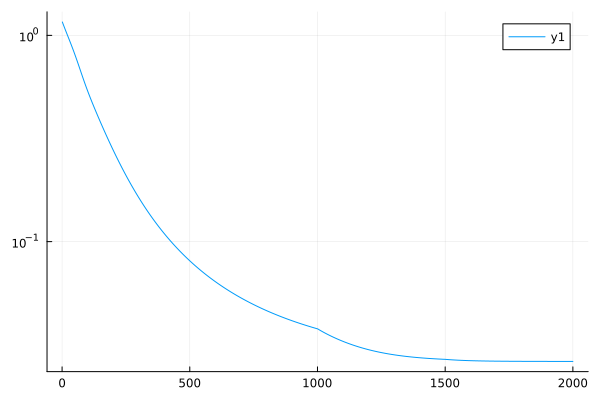

In [139]:
test1, lds1 = Petz_σ(test_dms, dim)
println(loss_KL(test1, test_dms, dim))
plot(lds1, yaxis=:log)

In [140]:
@show vec2dm(test1)
@show test_dms.s_dm - vec2dm(test1)

vec2dm(test1) = ComplexF32[0.37250975f0 + 0.0f0im 0.032461736f0 - 0.07777244f0im 0.064099565f0 + 0.12973288f0im -0.04718313f0 + 0.13450179f0im; 0.032461736f0 + 0.07777244f0im 0.3047053f0 + 0.0f0im 0.095414415f0 + 0.08614182f0im 0.08802388f0 + 0.02947213f0im; 0.064099565f0 - 0.12973288f0im 0.095414415f0 - 0.08614182f0im 0.1406742f0 + 0.0f0im 0.12715685f0 + 0.026005674f0im; -0.04718313f0 - 0.13450179f0im 0.08802388f0 - 0.02947213f0im 0.12715685f0 - 0.026005674f0im 0.18211076f0 + 0.0f0im]
test_dms.s_dm - vec2dm(test1) = ComplexF32[-0.09515509f0 + 0.0f0im 0.11677489f0 + 0.08255243f0im 0.01308389f0 + 0.021973506f0im 0.05031807f0 + 0.016481578f0im; 0.11677489f0 - 0.08255243f0im 0.045199692f0 + 0.0f0im 0.071691066f0 + 0.045718484f0im 0.026041098f0 + 0.058099084f0im; 0.01308389f0 - 0.021973506f0im 0.071691066f0 - 0.045718484f0im 0.047965616f0 + 0.0f0im 0.034881294f0 - 0.0017707795f0im; 0.05031807f0 - 0.016481578f0im 0.026041098f0 - 0.058099084f0im 0.034881294f0 + 0.0017707795f0im 0.0019897819f

4×4 Hermitian{ComplexF32, Matrix{ComplexF32}}:
 -0.0951551+0.0im         0.116775+0.0825524im  …   0.0503181+0.0164816im
   0.116775-0.0825524im  0.0451997+0.0im            0.0260411+0.0580991im
  0.0130839-0.0219735im  0.0716911-0.0457185im      0.0348813-0.00177078im
  0.0503181-0.0164816im  0.0260411-0.0580991im     0.00198978+0.0im

In [141]:
@show petz_dm = vec2dm(test1)
@show recov_test = PetzRecovery(Λρ(petz_dm, test_dms, dim), test_dms, dim)
petz_dm - recov_test

petz_dm = vec2dm(test1) = ComplexF32[0.37250975f0 + 0.0f0im 0.032461736f0 - 0.07777244f0im 0.064099565f0 + 0.12973288f0im -0.04718313f0 + 0.13450179f0im; 0.032461736f0 + 0.07777244f0im 0.3047053f0 + 0.0f0im 0.095414415f0 + 0.08614182f0im 0.08802388f0 + 0.02947213f0im; 0.064099565f0 - 0.12973288f0im 0.095414415f0 - 0.08614182f0im 0.1406742f0 + 0.0f0im 0.12715685f0 + 0.026005674f0im; -0.04718313f0 - 0.13450179f0im 0.08802388f0 - 0.02947213f0im 0.12715685f0 - 0.026005674f0im 0.18211076f0 + 0.0f0im]
recov_test = PetzRecovery(Λρ(petz_dm, test_dms, dim), test_dms, dim) = ComplexF32[0.29139578f0 + 0.0f0im 0.041600876f0 + 0.09870007f0im -0.0021205626f0 + 0.05487665f0im 0.030169386f0 + 0.12883666f0im; 0.041600876f0 - 0.09870007f0im 0.24225536f0 + 0.0f0im 0.02670309f0 + 0.07362546f0im 0.08662291f0 + 0.051626876f0im; -0.0021205626f0 - 0.05487665f0im 0.02670309f0 - 0.07362546f0im 0.23912306f0 + 0.0f0im 0.022631448f0 - 0.017022166f0im; 0.030169386f0 - 0.12883666f0im 0.08662291f0 - 0.051626876f0im 0

4×4 Hermitian{ComplexF32, Matrix{ComplexF32}}:
    0.081114+0.0im         …  -0.0773525+0.00566512im
 -0.00913914+0.176473im       0.00140097-0.0221547im
   0.0662201-0.0748562im        0.104525+0.0430278im
  -0.0773525-0.00566512im     -0.0451157+0.0im

In [142]:
using LinearAlgebra

In [146]:
test = rand(Float32, 4)
hh = vec2hermite(test)

2×2 Hermitian{ComplexF32, Matrix{ComplexF32}}:
 0.971354+0.0im       0.649136+0.757361im
 0.649136-0.757361im  0.649136+0.0im

In [147]:
e, v = eigen(hh)

Eigen{ComplexF32, Float32, Matrix{ComplexF32}, Vector{Float32}}
values:
2-element Vector{Float32}:
 -0.20016588
  1.8206556
vectors:
2×2 Matrix{ComplexF32}:
  0.421888+0.492226im  0.495496+0.578107im
 -0.761396+0.0im       0.648287+0.0im